In [55]:
# Import statements

import numpy as np
from pylab import *
from matplotlib import animation
import matplotlib.pyplot as plt

#ipython setting
rcParams['figure.figsize'] = (20, 12)

%matplotlib notebook

$\newcommand{\vecl}[1]{\begin{pmatrix}#1\end{pmatrix}}$ 
$\newcommand{\hvec}[1]{\widetilde{\boldsymbol{#1}}}$
$\newcommand{\nvec}[1]{\boldsymbol{#1}}$

## Pinhole camera

In this report we look at the calibration of a camera using the camera matrix P, which is given by

\begin{split}
    \nvec{P} &= \vecl{f_x & \alpha & u_0 & 0 \\
                      0   & f_y    & v_0 & 0 \\
                      0   & 0      & 1   & 0}
                \vecl{\nvec{R}^T & -\nvec{R}^T\nvec{t} \\
                      \nvec{0}^T & 1} \\
             &= \nvec{K}\nvec{E}
\end{split}

Here $\nvec{K}$ is the internal camera matrix which is dependent on the geometry of the camera, and is generally not know exactly. $\nvec{E}$ is the coordinate transformation matrix from the world coordinates to the coordinate frame of the camera, also known as the external matrix. In general this can be described by a rotation (given by $\nvec{R}$) and a translation (given by $\nvec{t}$). The coordinate transformation is the inverse of the frame transformation

\begin{split}
    \nvec{E} = \vecl{\nvec{R}   & \nvec{t} \\
                     \nvec{0}^T & 1        }
\end{split}


To determine the camera matrix $\nvec{P}$ exactly is in general impossible, therefore it is useful to find a way to estimate this matrix. To do this we need an expression for the full coordinate transformation

\begin{split}
    \nvec{x} &\sim \nvec{P}\nvec{X} \\
    \vecl{sx \\ sy \\ s} &= \nvec{P} \vecl{X\\ Y\\ Z\\ 1}
\end{split}

where $\nvec{x}$ is the coordinate vector in the 2D camera projection in homogeneous coordinates (which means it is a vector with 3 components) and $\nvec{X}$ is the coordinate vector of the point in real space coordinates as a homogeneous vector (thus having 4 components). The $\sim$ in the first equation shows that there is not an exact correspondence when applying the matrix. There is a scaling factor, s, associated with the transform as shown in the second equation. This means that there is an additional step to renormalize the homogeneous coordinates by multiplying by $\frac{1}{s}$. To get to an estimation of the matrix we can rewrite this as follows 

\begin{split}
    \vecl{ \nvec{X_1}^T & \nvec{0}^T   & -x_1 \nvec{X_1}^T \\
           \nvec{0}^T   & \nvec{X_1}^T & -y_1 \nvec{X_1}^T \\
           \vdots       &    \vdots    & \vdots            \\
           \nvec{X_n}^T & \nvec{0}^T   & -x_n \nvec{X_n}^T \\
           \nvec{0}^T   & \nvec{X_n}^T & -y_n \nvec{X_n}^T \\
           } \nvec{p} &= \nvec{0} \\
    \nvec{A}\nvec{p} &= \nvec{0}
\end{split}

where the vector $\nvec{p}$ is the matrix $\nvec{P}$ rewritten as a vector. This way we can easily try to determine the nullspace of the matrix (since the solution is the zero-vecor). For this we can use the svd-trick as described in Lab2. Basically we decompose the matrix and pick the 'eigenvector' corresponding to the smalles singular value. Which means that we take the last column of the matrix $\nvec{V}$ resulting from the singular value decomposition.

In [2]:
# Points determined in the chosen world frame
XYZ = array([[0, -5, 5], [0, -3, 5], [0, -1, 5], [-1, 0, 5],
             [-3, 0, 5], [-5, 0, 5], [0, -5, 3], [0, -3, 3],
             [0, -1, 3], [-1, 0, 3], [-3, 0, 3], [-5, 0, 3],
             [0, -5, 1], [0, -3, 1], [0, -1, 1], [-1, 0, 1],
             [-3, 0, 1], [-5, 0, 1]])

# Corresponding points in the projection
xy = array([[ 213.1027,  170.0499], [ 258.1908,  181.3219],
            [ 306.41  ,  193.8464], [ 351.498 ,  183.8268],
            [ 382.8092,  155.6468], [ 411.6155,  130.5978],
            [ 223.7485,  218.2691], [ 267.5841,  230.7935],
            [ 314.5509,  244.5705], [ 357.7603,  235.1771],
            [ 387.819 ,  205.1184], [ 415.3728,  178.1908],
            [ 234.3943,  263.9834], [ 276.9775,  277.1341],
            [ 323.318 ,  291.5372], [ 363.3963,  282.1438],
            [ 392.8288,  251.4589], [ 419.1301,  223.9051]])

# Estimates the camera matrix for the points xy corresponding to the world space points in 
# homogeneous coordinates.
def EstimateCameraMatrix(xy, XYZ_HC):  
    
    # Create 4-element zero vector for use in A-matrix
    z = np.array([0, 0, 0, 0])
    
    # Create A-matrix using list comprehension and making an array out of it
    A = np.array([np.hstack((XYZ_HC[int(n/2)], z       , -xy[int(n/2)][0] * XYZ_HC[int(n/2)])) if n % 2 == 0 else
                  np.hstack((z       , XYZ_HC[int(n/2)], -xy[int(n/2)][1] * XYZ_HC[int(n/2)])) for n in range(2 * len(xy))])
    
    # Decompose A using SVD
    U, D, V_t = np.linalg.svd(A)
    # Takin the last row of V_t (same as last column of V) and reshape to 3x4 matrix
    return V_t[-1].reshape((3, 4))

The function defined above does exactly that. The matrix $\nvec{A}$ is constructed and decomposed using SVD, after which the last row of $\nvec{V}^T$ is taken. This is done to save an additional transposition operation as we actually need the last column of $\nvec{V}$. In the following section of code the camera matrix is actually calculated and used to find the reprojection error of the matrix. This is done by simply applying the calculated camera matrix to all world space points and calculating the 2D-euclidean distance between the chosen points in projection space and the calculated points. Also, the chosen points and the calculated points are plotted into the image.

Reprojection error = 7.5900 pixels


<IPython.core.display.Javascript object>


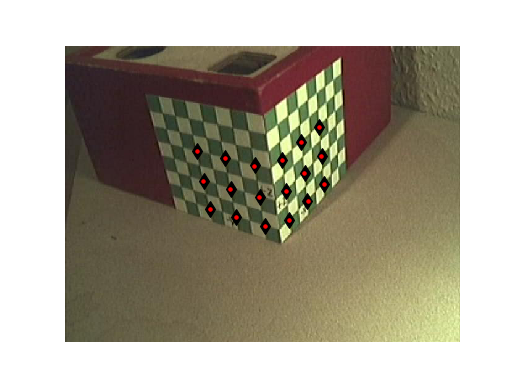

In [21]:
im = imread("calibrationpoints.jpg")

# Homogeneous 3D coordinates of world space (just appending 1 to every vector)
XYZ_HC = np.concatenate((XYZ, np.array([[1] for _ in range(len(XYZ))])), axis=1)
# Calculate the camera matrix
K = EstimateCameraMatrix(xy, XYZ_HC)

xy_calc = []
reprojectionError = 0

# Transform 3D points
for pt3D, pt2D in zip(XYZ_HC, xy):
    # Apply cmera matrix to all points
    pt = np.dot(K, pt3D)
    # Renormalise to scale factor 1
    pt_renorm = pt / pt[2]
    xy_calc.append(pt_renorm)
    # Calculate error per point and add
    reprojectionError += np.linalg.norm(pt2D - pt_renorm[:2])

# Make array out of calculated points for easier indexing and plotting
xy_calc = np.array(xy_calc)
print("Reprojection error = %.4f pixels" % (reprojectionError))

imshow(im)
# Plot calculated points as black diamonds
plot(xy_calc[:,0],xy_calc[:,1],'d', markersize = 10, color="black")
# Plot chosen points as red dots
plot(xy[:,0],xy[:,1],'r.')
axis('off')
axis('equal')
show()

As shown above, the reprojection error is about 7,6 pixels in discretised image space for 18 point correspondences. In this case that means an average error of 0,42 pixels per point. I added 6 extra points to the point correspondences and in the following code section the average error is checked for different amounts of points. Different simple permutations of the data show wildly different results for the reprojection error. Although it is very clear that 6 points is not enough for reliable estimation it is difficult to determine the accuracy of the results as the points that I added seem to have a larger error than the given points. This shows mostly in the 12 and 18 corresponednces estimation.

<IPython.core.display.Javascript object>


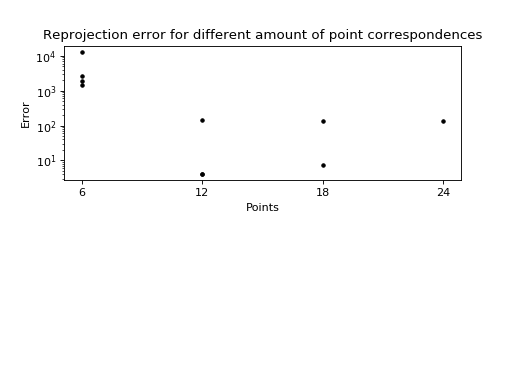

In [18]:
# Points determined in the chosen world frame
XYZ2 = array([[0, -5, 7], [0, -5, 7], [0, -1, 7], [-1, 0, 7], [-3, 0, 7], [-5, 0, 7],
              [0, -5, 5], [0, -3, 5], [0, -1, 5], [-1, 0, 5],
              [-3, 0, 5], [-5, 0, 5], [0, -5, 3], [0, -3, 3],
              [0, -1, 3], [-1, 0, 3], [-3, 0, 3], [-5, 0, 3],
              [0, -5, 1], [0, -3, 1], [0, -1, 1], [-1, 0, 1],
              [-3, 0, 1], [-5, 0, 1]])

# Corresponding points in the projection
xy2 = array([[ 202.66  ,   102.019], [ 248.115 ,   130.409], 
             [ 297.465 ,   136.903], [ 345.517 ,   130.409], 
             [ 379.284 ,   103.136], [ 410.452 ,   77.1623],
             [ 213.1027,  170.0499], [ 258.1908,  181.3219],
             [ 306.41  ,  193.8464], [ 351.498 ,  183.8268],
             [ 382.8092,  155.6468], [ 411.6155,  130.5978],
             [ 223.7485,  218.2691], [ 267.5841,  230.7935],
             [ 314.5509,  244.5705], [ 357.7603,  235.1771],
             [ 387.819 ,  205.1184], [ 415.3728,  178.1908],
             [ 234.3943,  263.9834], [ 276.9775,  277.1341],
             [ 323.318 ,  291.5372], [ 363.3963,  282.1438],
             [ 392.8288,  251.4589], [ 419.1301,  223.9051]])

# Homogeneous 3D coordinates of world space (just appending 1 to every vector)
XYZ_HC2 = np.concatenate((XYZ2, np.array([[1] for _ in range(len(XYZ2))])), axis=1)

# Set up iterable
indices = [(x, y) for x in range(0, 19, 6) for y in range(0, 25, 6) if x < y]
error_list = []

for start, stop in indices:

    reprojection_error = 0
    xy_selection = xy2[start:stop]
    XYZ_HC_selection = XYZ_HC2[start:stop]
    K_temp = EstimateCameraMatrix(xy_selection, XYZ_HC_selection)
    
    # Transform 3D points
    for pt3D, pt2D in zip(XYZ_HC_selection, xy_selection):
        # Apply cmera matrix to all points
        pt = np.dot(K_temp, pt3D)
        # Renormalise to scale factor 1
        pt_renorm = pt / pt[2]
        # Calculate error per point and add
        reprojection_error += np.linalg.norm(pt2D - pt_renorm[:2])
        
    error_list.append(reprojection_error)

amount_points = [abs(x - y) for x, y in indices]

fig = plt.figure()
ax = fig.add_subplot(2,1,1)

ax.set_title("Reprojection error for different amount of point correspondences")
ax.plot(amount_points, error_list, 'k.')
ax.set_xlabel("Points")
ax.set_ylabel("Error")
ax.set_yscale('log')
ax.set_xticks([6, 12, 18, 24])
plt.show()

Finally, we can use the camera matrix to draw figures in an image using world space coordinates. By using the line drawing utilities of matplotlib we can give the plot function a collection of vertices between which a line has to be drawn, this can be used to define a cube in 3D world space which we can transform using the camera matrix. In the following section three cubes are drawn on the line x = y (z=0) and it can clearly be seen that the cubes show perspective in the fact that they look rotated and scaled according to percieved distance. The cube furthest is actually inside the object, but since the camera matrix has no knowledge of where objects are, it is still drawn as if there would be nothing there.

<IPython.core.display.Javascript object>


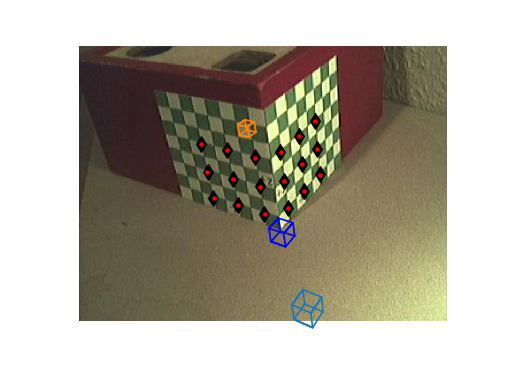

In [32]:
def makeCube(K, x, y, z):
    
    # Setup vertices and line, first row is bottom plane, second row is top plane, third row defines interconnects
    cube = np.array([[x, y, z    , 1], [x + 1, y, z    , 1], [x + 1, y + 1, z    , 1], [x, y + 1, z    , 1], [x, y, z    , 1],
                     [x, y, z + 1, 1], [x + 1, y, z + 1, 1], [x + 1, y + 1, z + 1, 1], [x, y + 1, z + 1, 1], [x, y, z + 1, 1],
                     [x + 1, y, z + 1, 1], [x + 1, y, z, 1], [x + 1, y + 1, z    , 1], [x + 1, y + 1, z + 1, 1], [x, y + 1, z + 1, 1], [x, y + 1, z, 1]])
    # Transform according to given camera matrix
    cube_xy = np.array([np.dot(K, c) for c in cube])
    cube_xy = np.array([c / c[2] for c in cube_xy])
    
    # Format as plot function wants it (seperate x and y lists)
    xs = cube_xy.T[0]
    ys = cube_xy.T[1]
    
    return xs, ys

xs, ys = makeCube(K, 0, 0, 0)
xs1, ys1 = makeCube(K, 4, 4, 0)
xs2, ys2 = makeCube(K, -10, -10, 0)

imshow(im)
plot(xy_calc[:,0],xy_calc[:,1],'d', markersize = 10, color="black")
plot(xy[:,0],xy[:,1],'r.')
plot(xs, ys, 'b-')
plot(xs1, ys1)
plot(xs2, ys2)
axis('off')
axis('equal')
show()

Finally, using the makeCube function, an animation can be constructed in which a cube moves through the image as if it is actually in the picture. To make it seem as though the cube actually goes through the object, inside the animation function the linestyle and alpha of the cube are adapted depending on where it is in world space. This is done in an extremely naive and simple manner, but in this case it does the job quite well.

An animation was saved and is supplied in the turned in tarball.

<IPython.core.display.Javascript object>


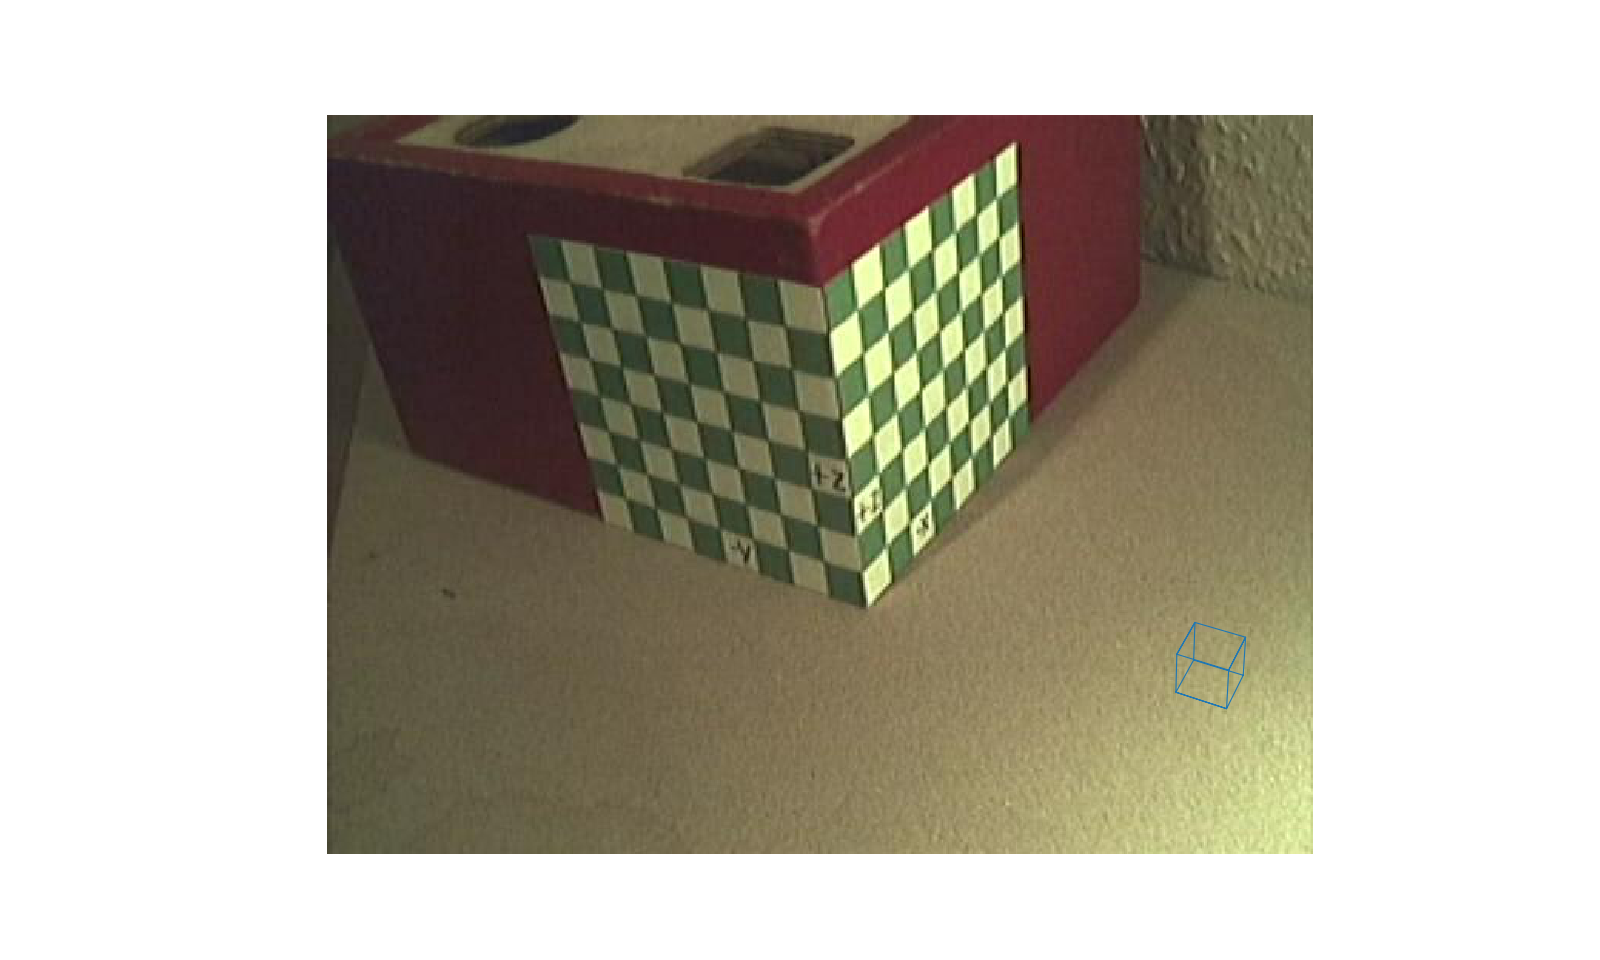

In [54]:
# For moving along the circle X^2 + Y^2 = 49 we can parametrize this with an angle and a radius
# Where the angle goes from 0 to 2pi and the radius is sqrt(49) = 7
# Make figure and axis
fig, ax = plt.subplots()

line, = ax.plot([], [])

def animate(i):
    # Calculate new location of cube, every frame it moves 1 degree
    X = 7 * np.cos(i*(np.pi/180))
    Y = 7 * np.sin(i*(np.pi/180))
    # Make cube vertices
    xs, ys = makeCube(K, X, Y, 0)
    # Depending on whether cube is inside object, change linestyle and alpha
    line.set_linestyle('-.' if X < 0 and Y < 0 else '-')
    line.set_alpha(.5 if X < 0 and Y < 0 else 1 )
    # Set new data
    line.set_xdata(xs)
    line.set_ydata(ys) 
    
    return line,

# Init only required for blitting to give a clean slate.
def init():
    plt.imshow(im)
    line.set_linewidth(1)
    return line,

plt.axis("off")
# Animate for 360 frames, thus moving one circle
ani = animation.FuncAnimation(fig, animate, 360, init_func=init,
                              interval=35, blit=True)
plt.show()